In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import popoff
from Session import SessionLite, build_flu_array_single
from mpl_toolkits.mplot3d import Axes3D
from linear_model import PoolAcrossSessions, LinearModel, pca_session, LabelEncoder, largest_PC_trace, largest_PC_loading, do_pca
import loadpaths
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import os
import pickle
import copy
from scipy import stats, signal
from sklearn.decomposition import PCA
import statsmodels.api as sm
from scipy.stats import lognorm
import warnings

from IPython.core.debugger import Pdb
ipdb = Pdb()

# sys.path.append(os.path.expanduser('~/Documents/code/PtitPrince/pititprince'))
import ptitprince as pt


user_paths_dict = loadpaths.loadpaths()

path_to_vape = user_paths_dict['vape_path']

sys.path.append(path_to_vape)
sys.path.append(os.path.join(path_to_vape, 'jupyter'))
sys.path.append(os.path.join(path_to_vape, 'utils'))

import utils_funcs as utils 

In [72]:
user_paths = loadpaths.loadpaths()
sys.path.append(user_paths['base_path'])
figure_path = '/home/jrowland/mnt/qnap/Figures/bois'
# from pySpatialNeuronNet import factor_analysis

In [73]:
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

## Load Both PoolAcrossSessions class and example LinearModel class
* PoolAcrossSessions loads 4 example sessions and has an attribute 'linear_models', a list of len n_sessions containing a LinearModel object for every session
* The PoolAcrossSessions class has methods that match the methods in LinearModel, producing the same plots across sessions
* PAS also computes PC array for each session and saves it into the object. This can be recomputed by setting save_PCA=True.


In [74]:
warnings.warn('Targets in data, fix self.ever_targetted')
remove_targets = True
pas = PoolAcrossSessions(save_PCA=False, remove_targets=remove_targets)
lm = pas.linear_models[0]
pas.sessions

{3: instance Mouse J064, run 10 of Session class,
 7: instance Mouse RL070, run 29 of Session class,
 0: instance Mouse J065, run 10 of Session class}

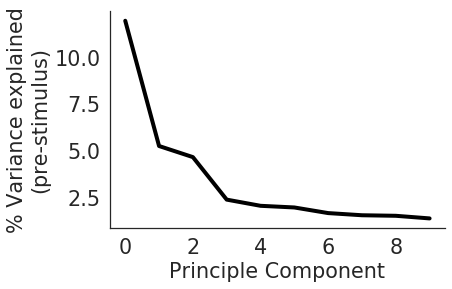

In [62]:
trial = lm.flu[:, 10, :]
_ = do_pca(trial, 10, plot=True)

(0.4, 1)

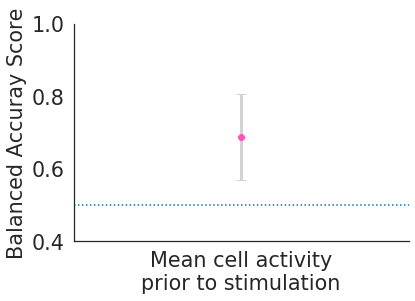

In [24]:
pas.compare_regions(frames = 'pre')
plt.ylabel('Balanced Accuray Score')
plt.ylim(0.4, 1)

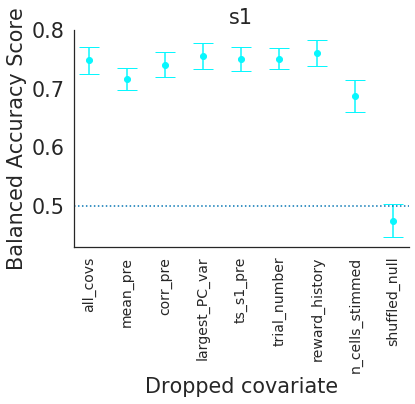

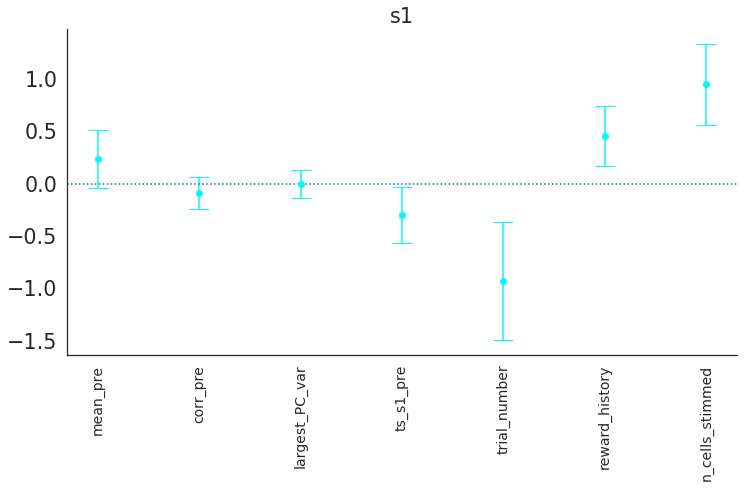

In [6]:
pas.dropout(region='s1')

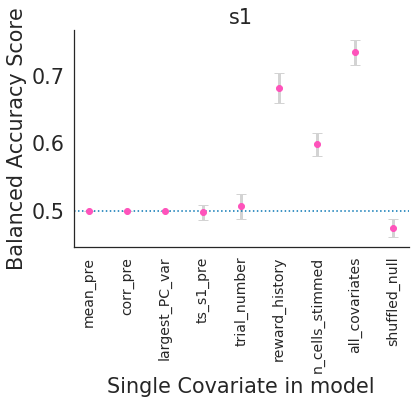

In [7]:
pas.single_covariate(region='s1')

In [8]:
flu = lm.flu[lm.region_map['s1'], :, :]
comps = np.array(largest_PC_trace(flu, lm.pre))
comps.shape

(132, 59)

(-5, 5)

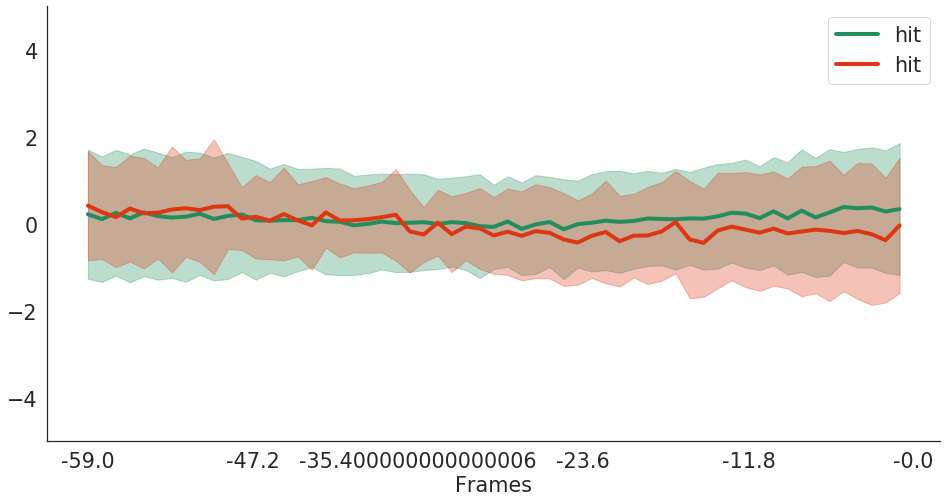

In [9]:
plt.figure(figsize=(16,8))
hit_mean = []
miss_mean = []
for comp, outcome in zip(comps, lm.session.outcome):
    
    if outcome == 'hit':
#         plt.plot(comp, COLORS[0], alpha=0.2)
        hit_mean.append(comp)
    if outcome == 'miss':
#         plt.plot(comp, COLORS[1], alpha=0.2)
        miss_mean.append(comp)
   
hit_mean = np.array(hit_mean)
miss_mean = np.array(miss_mean)

plt.plot(np.mean(hit_mean, 0), COLORS[0], lw=4, label='hit')
plt.fill_between(np.arange(hit_mean.shape[1]), 
                 np.mean(hit_mean, 0) + np.std(hit_mean, 0),
                 np.mean(hit_mean, 0) - np.std(hit_mean, 0),
                 color=COLORS[0], alpha=0.3)

plt.plot(np.mean(miss_mean, 0), COLORS[1], lw=4, label='hit')
plt.fill_between(np.arange(miss_mean.shape[1]), 
                 np.mean(miss_mean, 0) + np.std(miss_mean, 0),
                 np.mean(miss_mean, 0) - np.std(miss_mean, 0),
                 color=COLORS[1], alpha=0.3)

plt.legend()
plt.xlabel('Frames')
ticks = np.linspace(0, len(comp), 6)
_ = plt.xticks(ticks, np.flip(ticks*-1))
plt.ylim(-5,5)


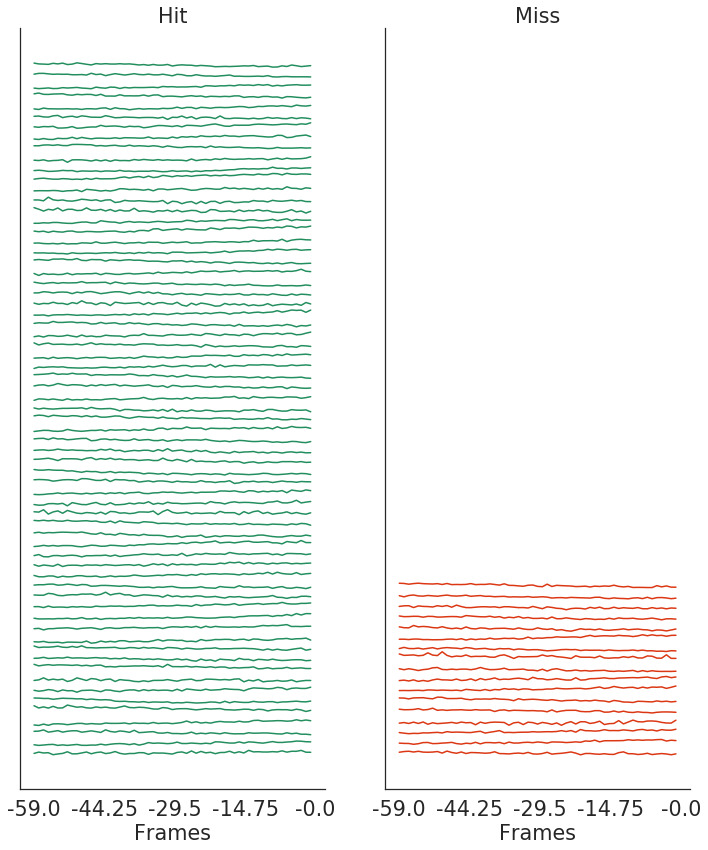

In [11]:
plt.figure(figsize=(12,14))
n = 0
y_offset = 8

plt.subplot(1,2,1)
for idx, comp in enumerate(comps[lm.session.outcome=='hit']):
    plt.plot(comp+idx*y_offset, color=COLORS[0])
    plt.title('Hit')
    plt.yticks([])
    plt.xlabel('Frames')
    ticks = np.linspace(0, len(comp), 5)
    _ = plt.xticks(ticks, np.flip(ticks*-1))
    ylims = plt.gca().get_ylim()
#     plt.ylim(0,2.8)
    
plt.subplot(1,2,2)

for idx, comp in enumerate(comps[lm.session.outcome=='miss']):
    plt.plot(comp+idx*y_offset, color=COLORS[1])
    plt.title('Miss')
    plt.yticks([])
    plt.xlabel('Frames')
    ticks = np.linspace(0, len(comp), 5)
    _ = plt.xticks(ticks, np.flip(ticks*-1))
    plt.ylim(ylims)
    

In [12]:
loadings = largest_PC_loading(flu, lm.pre)

hit = loadings[lm.session.outcome=='hit']
miss = loadings[lm.session.outcome=='miss']

Text(0, 0.5, 'Mean loading weight\n(across trials)')

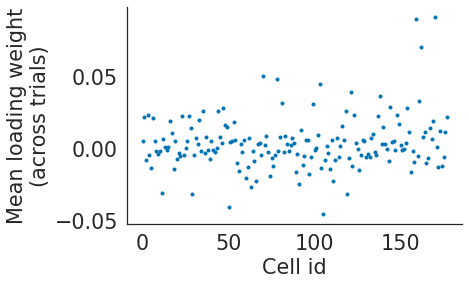

In [13]:
plt.plot(np.arange(miss.shape[1]), np.mean(miss, 0), '.')
plt.xlabel('Cell id')
plt.ylabel('Mean loading weight\n(across trials)')

In [62]:
flu = lm.session.flu[lm.session.filtered_neurons, :]
flu = flu[~lm.ever_targetted]
flu = flu[lm.region_map['s1'], :]

shit_idx = np.argmax(np.mean(miss, 0))
shit_cell = flu[shit_idx, :]

Text(0.5, 0, 'Neuron Loading')

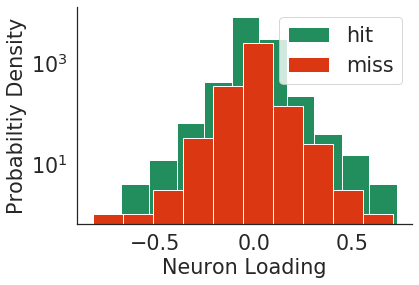

In [16]:
n = 10
plt.hist(np.concatenate(hit), n, color=COLORS[0], label='hit')
plt.hist(np.concatenate(miss), n, color=COLORS[1], label='miss')
plt.yscale('log')
plt.legend()
plt.ylabel('Probabiltiy Density')
plt.xlabel('Neuron Loading')

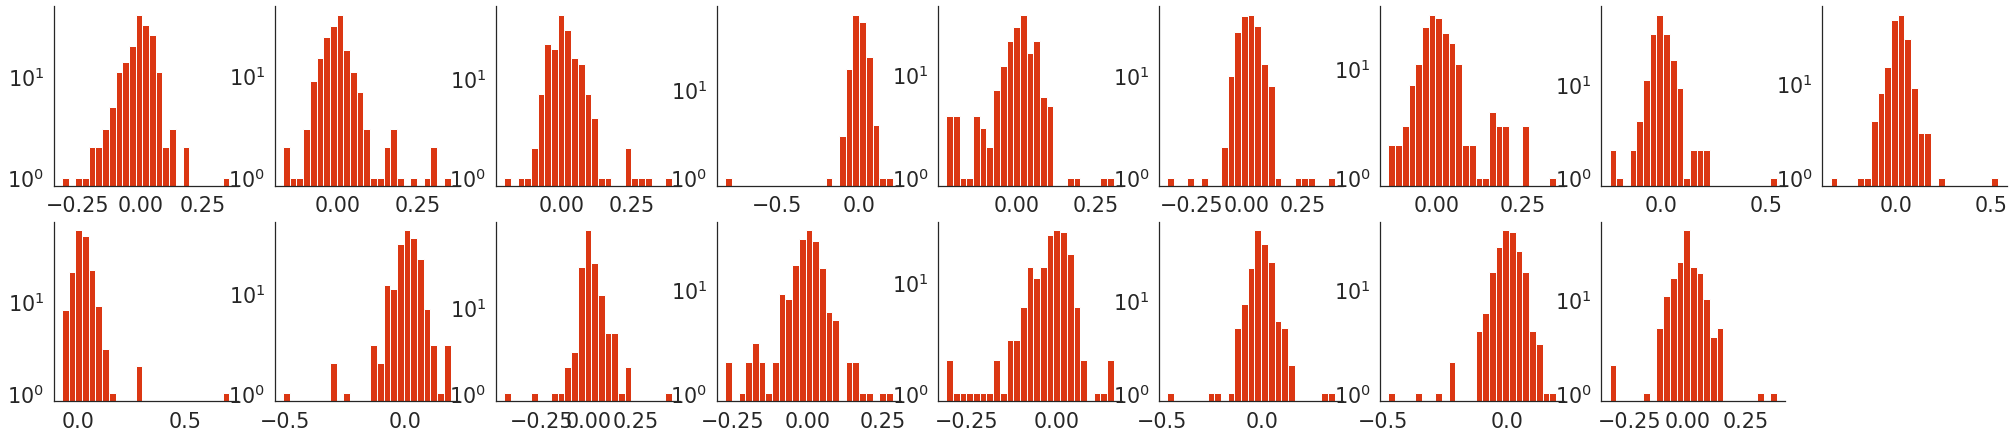

In [17]:
n = 25

plt.figure(figsize=(35,35))
n_plots = 0
for trial in miss:
    n_plots += 1
    plt.subplot(9,9,n_plots)
    plt.hist(trial, n, color=COLORS[1])
    
# plt.hist(np.concatenate(miss), n, color=COLORS[1], label='miss')
    plt.yscale('log')
# plt.legend()
# plt.ylabel('Probabiltiy Density')
# plt.xlabel('Neuron Loading')

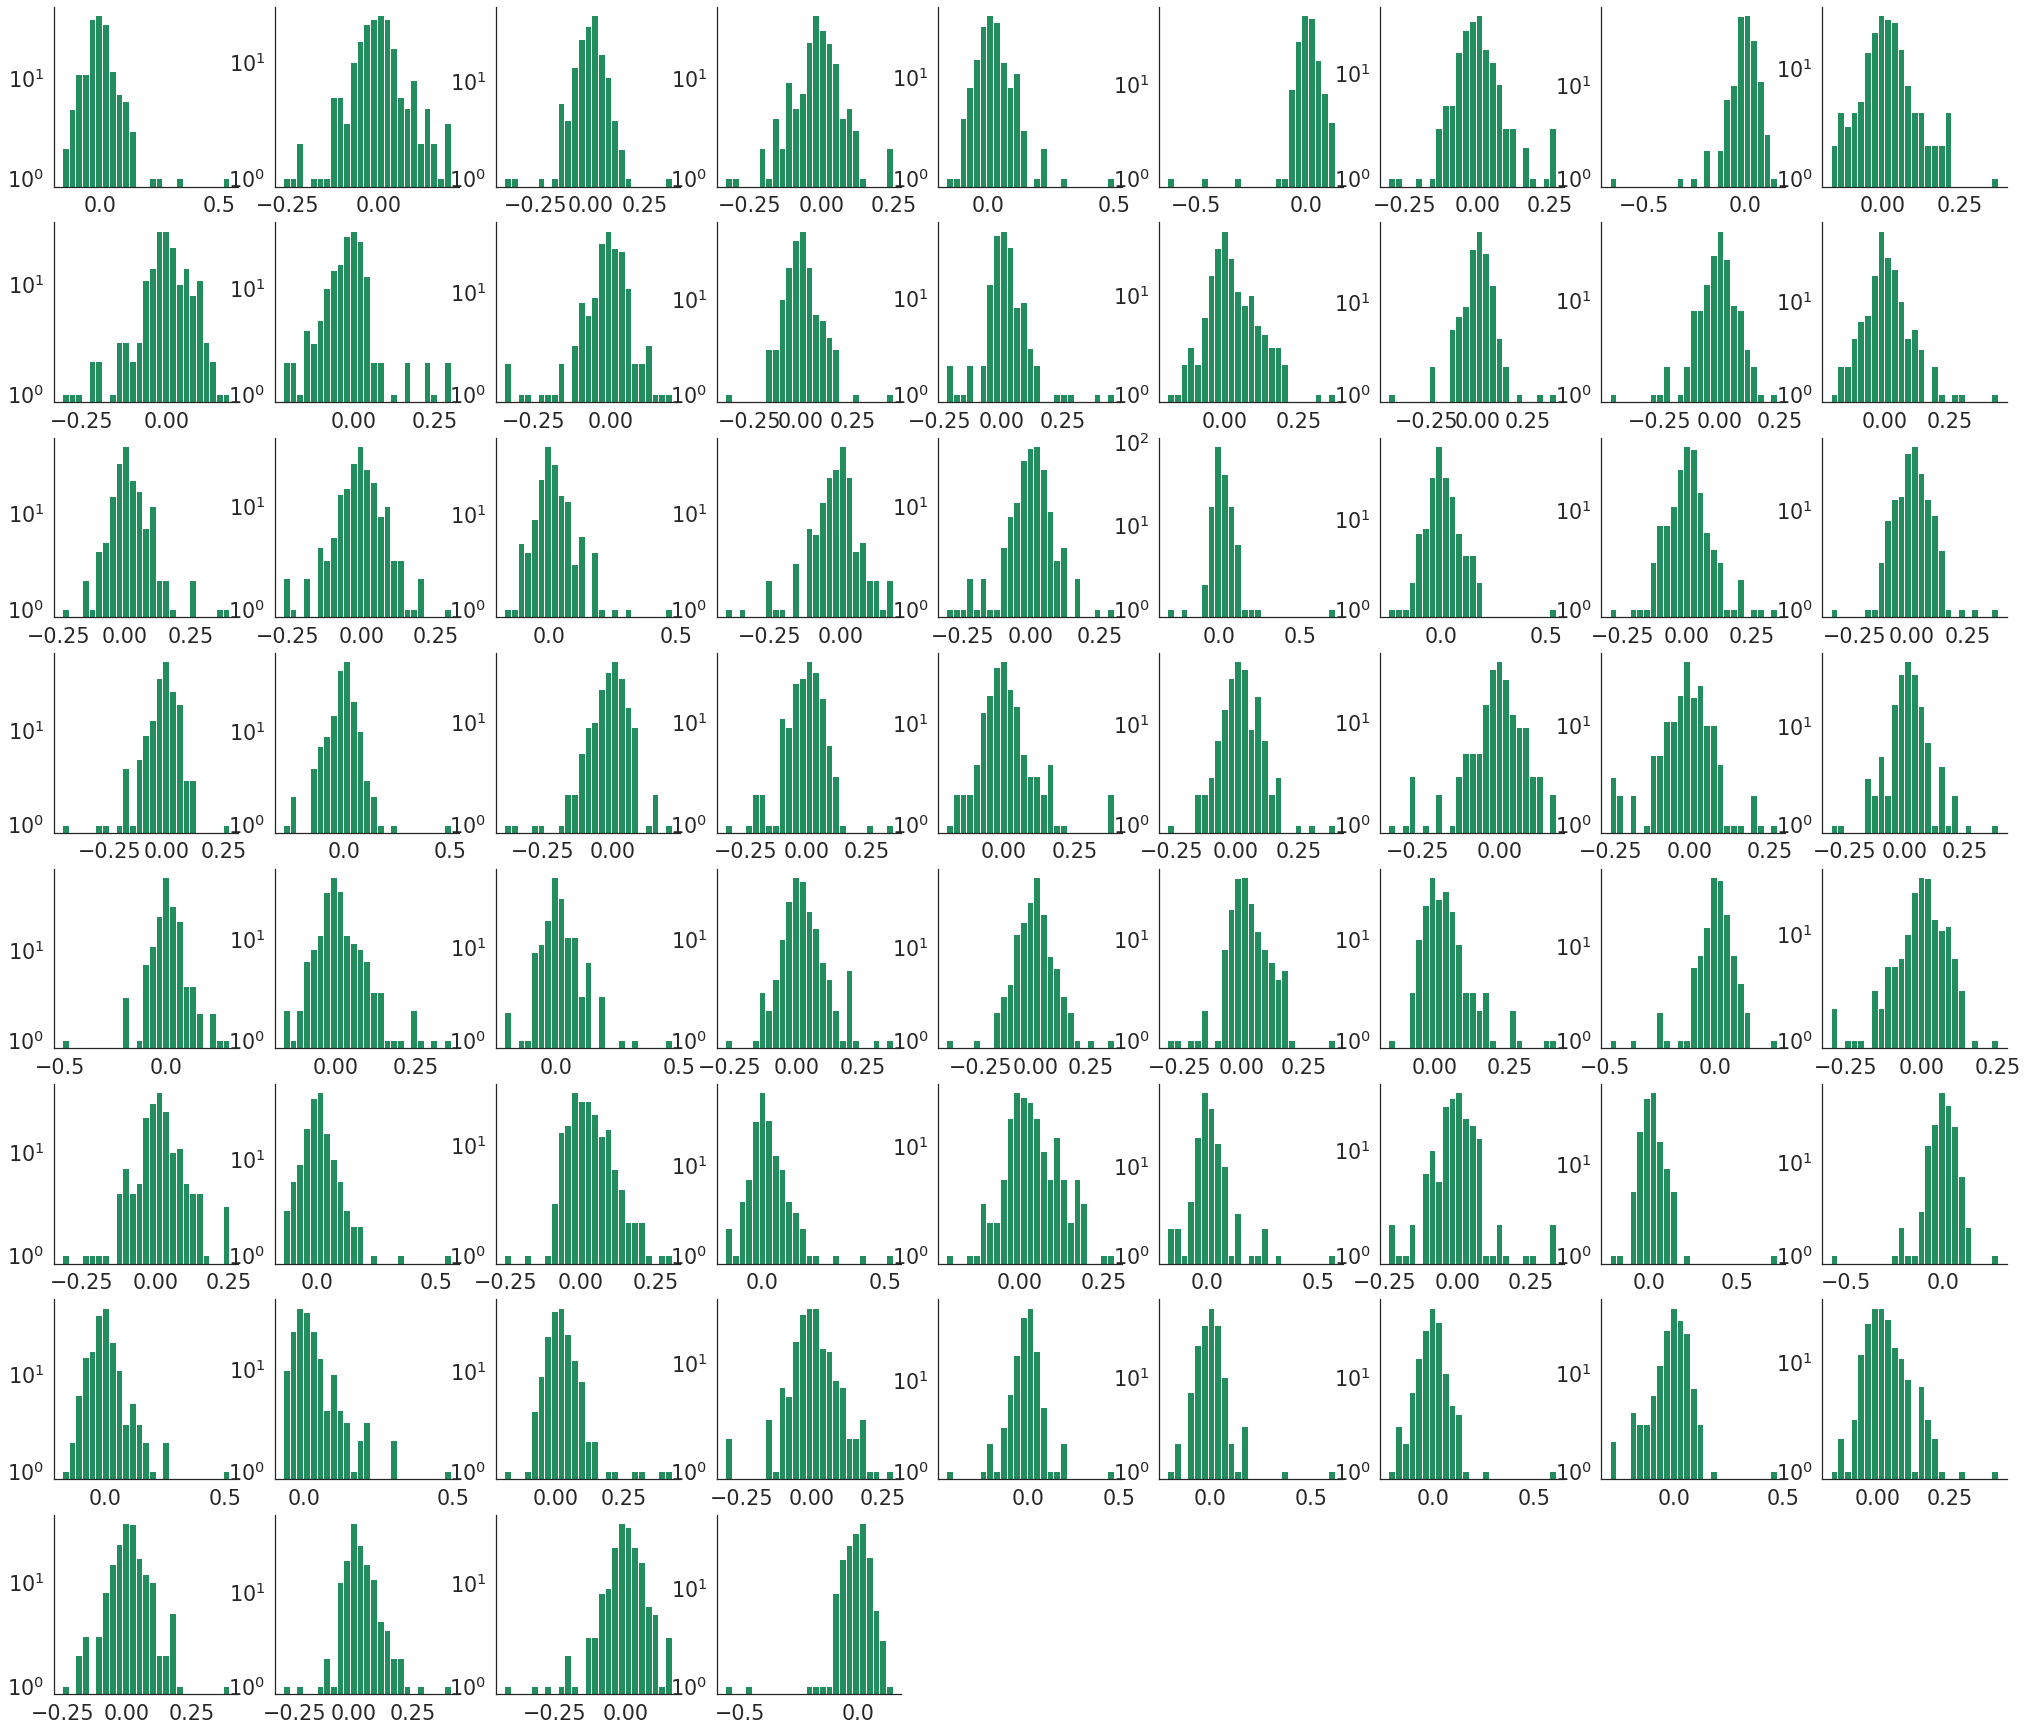

In [18]:
n = 25

plt.figure(figsize=(35,35))
n_plots = 0
for trial in hit:
    n_plots += 1
    plt.subplot(9,9,n_plots)
    plt.hist(trial, n, color=COLORS[0])
    
# plt.hist(np.concatenate(miss), n, color=COLORS[1], label='miss')
    plt.yscale('log')
# plt.legend()
# plt.ylabel('Probabiltiy Density')
# plt.xlabel('Neuron Loading')


### Allows you to eyeball distribution of covariates on different trial types

In [39]:
def get_covariates(lm, region):
    
    covariate_dict, y = lm.prepare_data('all', 'partial', n_comps_include=0,
                            outcomes=['hit', 'miss'],
                            region=region, return_matrix=False)
    
    covariate_dict['y'] = y
    
    return covariate_dict

In [40]:
def no_norm(x):
    return x

In [66]:
region = 's1'
cov_dicts = []
for linear_model in pas.linear_models:
    cov_dicts.append(get_covariates(linear_model, region))
    
data_dict = {}
dont_normalise = ['reward_history', 'n_cells_stimmed', 'y', 'trial_number']

for cov_dict in cov_dicts:
    for k, v in cov_dict.items():
        
        if k not in dont_normalise:
#             norm_func = stats.zscore
            print("ELLLO NO NORM HERE")
            norm_func = no_norm
        else:
            norm_func = no_norm
            
        if k not in data_dict:
            data_dict[k] = norm_func(v)
        else:
            data_dict[k] = np.append(data_dict[k], (norm_func(v)))
            

ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE
ELLLO NO NORM HERE


Text(0.5, 0.98, 'S1')

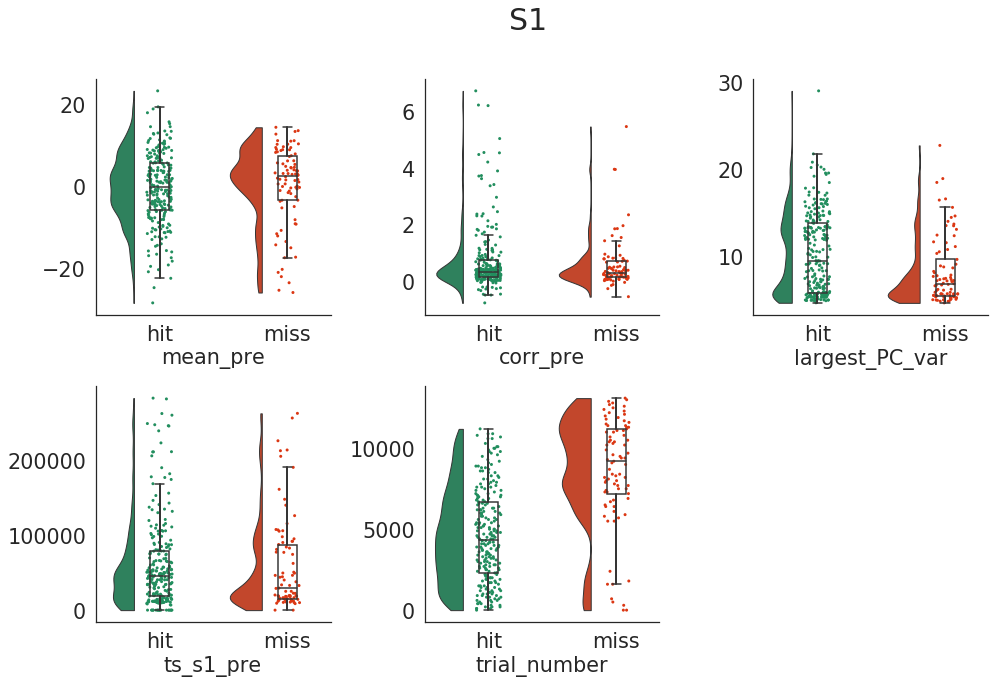

In [67]:
ort = "v"; pal = "Set2"; sigma = .2

covs_keep = ['mean_pre', 'corr_pre', 'largest_PC_var',
             f'ts_{region}_pre', 'reward_history', 'trial_number', 'n_cells_stimmed']

plt.figure(figsize=(16,10))
n_plots = 0

for cov_name in covs_keep:
    if cov_name in ['reward_history', 'n_cells_stimmed']:
        continue
    n_plots += 1
    ax = plt.subplot(2,3,n_plots)
    data = data_dict[cov_name] * 100
    ax=pt.RainCloud(data = [data[data_dict['y']==1], data[data_dict['y']==0]], palette = [COLORS[0], COLORS[1]], bw = sigma,
                     width_viol = .5, ax = ax, orient = ort, showfliers=False, linecolor=[COLORS[0], COLORS[0]])
#     plt.xlabel('% Variance Explained\nby the 1st PC')
    plt.xlabel(cov_name)
    plt.xticks([0,1], ['hit', 'miss'])
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.suptitle(region.upper(), fontsize=30)


In [69]:
from scipy.stats import mannwhitneyu
data = data_dict['largest_PC_var']
mannwhitneyu(data[data_dict['y']==1], data[data_dict['y']==0])

MannwhitneyuResult(statistic=7600.0, pvalue=8.737733611112045e-05)

In [ ]:
def kl_divergence(p, q):
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [ ]:
def norm_fit_bak(data, color, label):

    # Fit a normal distribution to the data:
    mu, std = stats.norm.fit(data)

    # Plot the histogram.
    plt.hist(data, bins=25, density=True, alpha=0.6, color=color)

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, len(data))
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, color=color)
    plt.xlabel(label)

In [ ]:
def norm_fit(data, color, xlabel, legend, xpos_text=0.5, ypos_text=1):
    
    # Fit a normal distribution to the data:
    mu, std = stats.norm.fit(data)
    
    # Plot the histogram.
    plt.hist(data, bins=25, density=True, alpha=0.6, color=color)
    
    x = np.linspace(min(data), max(data), len(data))
    pdf = stats.norm.pdf(x, mu, std)
    
    plt.plot(x, pdf, color=color, lw=3, label=legend)
    
    plt.xlabel(xlabel)
    plt.ylabel('Probability Density')
    plt.text(xpos_text, ypos_text, 
             f'KL(Data || Norm) = {round(kl_divergence(data, pdf), 2)}', 
             color=color, fontsize=16)
    plt.legend(loc='lower right')


In [ ]:
def lognorm_fit(data, color, xlabel, legend, xpos_text=0.5, ypos_text=1):
    
    shape,loc,scale = lognorm.fit(data)
    x = np.linspace(min(data), max(data), len(data))
    pdf = lognorm.pdf(x, shape, loc, scale)
    
    # Plot the histogram.
    plt.hist(data, bins=25, density=True, alpha=0.6, color=color)
    plt.plot(x, pdf, color=color, lw=3, label=legend)
    
    plt.xlabel(xlabel)
    plt.ylabel('Probability Density')
#     plt.text(xpos_text, ypos_text, 
#              f'KL(Data || Lognorm) = {round(kl_divergence(np.sort(data), pdf), 2)}', 
#              color=color, fontsize=16)
    plt.legend(loc='lower right')


In [ ]:
def norm_and_lognorm(data, color, xlabel):
    
    # X axis to plot fits on
    x = np.linspace(min(data), max(data), len(data))
    
    # Fit a normal distribution to the data:
    mu, std = stats.norm.fit(data)
    norm_pdf = stats.norm.pdf(x, mu, std)
    
    # Fit a lognormal distribution to the data:
    shape,loc,scale = lognorm.fit(data, loc=np.mean(data), scale=np.std(data))
    log_pdf = lognorm.pdf(x, shape, loc, scale)
    
    # Plot the histogram.
    plt.hist(data, bins=25, density=True, alpha=0.6, color=color)
    
    # Plot the fits
    plt.plot(x, norm_pdf, color=color, lw=3, label='norm')
    plt.plot(x, log_pdf, '--', color=color, lw=3, label='lognorm')
    
    # Write the KL divergences on the plot
    xpos_text = plt.gca().get_xlim()[1]/2
    ypos_text = plt.gca().get_ylim()[1]/1.5
    plt.text(xpos_text, ypos_text, 
             f'KL(Data || Norm) = {round(kl_divergence(data, norm_pdf), 1)}\n'
             f'KL(Data || Lognorm) = {round(kl_divergence(data, log_pdf), 1)}',
             color=color, fontsize=16)
    
    plt.legend(bbox_to_anchor=[1.2, 0.5])
    plt.xlabel(xlabel)
    plt.ylabel('Probability Density')

In [ ]:
covs_keep = ['mean_pre', 'corr_pre', 'largest_PC_var',
             f'ts_{region}_pre', 'trial_number']

plt.figure(figsize=(20,10))
for idx, cov_name in enumerate(covs_keep):
    plt.subplot(2,3,idx+1)
    data = data_dict[cov_name]
    data = data - min(data)
    data[data==0] = 0.00001
    norm_and_lognorm(data, 'black', cov_name)
plt.subplots_adjust(wspace=1.8, hspace=0.3)

NameError: name 'hit' is not defined

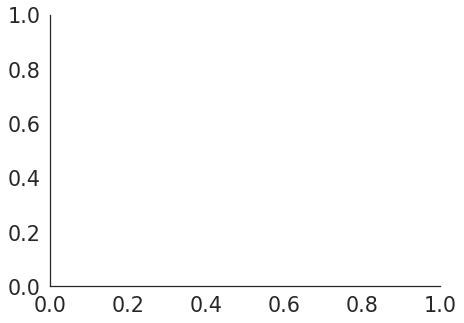

In [34]:
pal = "Set2"
ort = "v"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(7, 5))

# ax=pt.half_violinplot(data=hit, palette = pal, bw = .2, cut = 0.,
#                       scale = "area", width = .6, inner = None, orient = ort)
# ax=sns.stripplot(data = hit, palette = pal, edgecolor = "white",
#                  size = 3, jitter = 1, zorder = 0, orient = ort)
# ax=sns.boxplot(data=hit, color = "black", width = .15, zorder = 10,\
#             showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
#             showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
#                saturation = 1, orient = ort)

# ax=pt.half_violinplot(data=miss, palette = pal, bw = .2, cut = 0.,
#                       scale = "area", width = .6, inner = None, orient = ort)
# ax=sns.stripplot(data = miss, palette = pal, edgecolor = "white",
#                  size = 3, jitter = 1, zorder = 0, orient = ort)
# ax=sns.boxplot(data=miss, color = "black", width = .15, zorder = 10,\
#             showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
#             showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
#                saturation = 1, orient = ort)

ax=pt.RainCloud(data = [hit, miss], palette =[COLORS[0], COLORS[1]], bw = sigma,
                 width_viol = .5, ax = ax, orient = ort, showfliers=False, linecolor=[COLORS[0], COLORS[0]])
plt.savefig(os.path.join(figure_path, 'rainboi.pdf'),bbox_inches="tight")
plt.savefig(os.path.join(figure_path, 'rainboi.png'),bbox_inches="tight")

In [ ]:
stats.mannwhitneyu(hit, miss, alternative='two-sided')


In [ ]:
# Build this into pas as a function witht eh previous bit called on init 
region = 's2'

# This is shit
if region == 's1':
    covariates_list = s1_covariates
else:
    covariates_list = s2_covariates

covariate = 'ts_s1_pre'
plt.figure(figsize=(16,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

trials_include = ['hit', 'miss']

for idx, trial_type in enumerate(trials_include):
    
    trials_use = [linear_model.session.outcome[linear_model.session.nonnan_trials] == trial_type 
                  for linear_model in pas.linear_models]
    
    data = [cov_dict[covariate][trials] for cov_dict, trials in zip(covariates_list, trials_use)]
    
    data = np.concatenate(data)
#     trial_corrs[trial_type] = data
    
    ax1.errorbar([idx], np.mean(data), np.std(data)/len(data), capsize=20, label=trial_type)
    
    plot_hist(data, color=COLORS[idx], label=trial_type, covariate_name=covariate, include_bars=True)
    
plt.legend()
plt.suptitle(region.upper(), fontsize=25)

_ = ax1.set_xticks(np.arange(len(trials_include)))
_ = ax1.set_xticklabels(trials_include)
ax1.set_ylabel(covariate)

In [ ]:
def get_signal_corr(lm, region='all'):
    
    # Get signal correlations to 150 cell stim
    # Just easy trials
    
    arr = lm.flu[:, lm.session.photostim==2, :]
    arr = arr[:, :, lm.post]
    arr = arr[lm.region_map[region], :, :]
    tuning_matrix = np.mean(arr, 1)
    
    return np.corrcoef(tuning_matrix) 

In [ ]:
off_diagonal = lambda A: A[np.where(~np.eye(A.shape[0],dtype=bool))]


In [ ]:
plt.figure(figsize=(16,5))
for idx, region in enumerate(['s1', 's2']):
    plt.subplot(1,2,idx+1)
    signal_corr = get_signal_corr(lm, region=region)
    plt.imshow(signal_corr)
    plt.colorbar()
    plt.title(f'{region}, mean = {round(np.mean(off_diagonal(signal_corr)), 4)}')

### From the Panzeri paper

We quantified across-time and across-neuron pairwise noise correlations separately for trials in which mice made correct orerror choices.In order to discount possible differences in correlation related to trials  numerosity,  we  subsampled  trials  to  equalize  the  number  of  correct  and  error  trials  in  each recorded session. The subsampling procedure was repeated 20 times, and results were averaged over the 20 subsamples

We quantified across-neuron pairwise correlations by computing the Pearson correlation for each pair of neurons recorded in a single session, across trials sharing the same stimulus category. Results were averaged first across stimuli and then across trials subsamples.

In [ ]:
session = lm.session
fig = plt.figure(figsize=(18,18))
for comp in range(10):
    plt.subplot(4,3,comp+1)
    
    comps_arr = session.comps[:, :, session.frames_use]
    comps_arr = comps_arr[comp, :, :]


    for idx, trial_type in enumerate(['hit', 'miss', 'fp', 'cr']):
        arr = comps_arr[session.outcome[session.nonnan_trials]==trial_type, :]
        to_plot = np.mean(arr, 0)
        err_plot = np.std(arr, 0) * 10e-10

        to_plot[~lm.remove_artifact] = np.nan
        plt.plot(lm.times_use, to_plot,
                 color=COLORS[idx], label=trial_type,
                 )
        plt.fill_between(lm.times_use, to_plot-err_plot, to_plot+err_plot, color=COLORS[idx],
                        alpha=0.3)


    if comp==9:
        plt.legend(bbox_to_anchor=(1.05, 1))
    plt.xlabel('Time (seconds)')
    plt.title(f'PC {comp}')

fig.tight_layout(pad=1.0)



In [ ]:
# Get your manifold out
outcomes = session.outcome[session.nonnan_trials]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for idx, outcome in enumerate(['hit', 'miss', 'fp']):
    PCs = lm.session.comps[:, outcomes==outcome, :]
    PCs = np.mean(PCs, 1)
    ax.plot(xs=PCs[1,:], ys=PCs[7,:], zs=PCs[8,:], label=outcome, color=COLORS[idx])
    
ax.set_xlabel('PC 7')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 8')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.legend(bbox_to_anchor=(1.5,0.8))

## Can you decode just from s2 and/or just from pre-frames?

In [ ]:
plt.figure(figsize=(20,6))

n_plots = 0
for frames in ['pre', 'post', 'all', 'subbed']:
    n_plots += 1
    plt.subplot(1,4,n_plots)
    pas.compare_regions(frames=frames)
    plt.title(frames)
plt.ylabel('Classification Accuracy')

## Uneven trial numbers can lead to bias, so check bias is not too strong

In [ ]:
lm = LinearModel(session, pas.times_use)
X, y = lm.prepare_data(model='full', outcomes=['hit', 'miss', 'fp', 'cr'])
acc, std_acc, models = lm.logistic_regression(X, y, 'l1', 0.5, 'saga', compute_confusion=True)

C = np.sum(lm.confusion_matrix, 2)
cmd = ConfusionMatrixDisplay(C, display_labels=lm.encoder.inverse_transform([0,1,2,3]))
cmd.plot(cmap ='Blues')

In [ ]:
pas.build_confusion_matrix()

## Does the target info of the cell impact the model coefs?

In [ ]:
# Re-init the linear_model class with targets
lm = LinearModel(session, pas.times_use, remove_targets=False)
lm.beta_targets_correlation('s1')

In [ ]:
lm.beta_targets_correlation('s2')

In [ ]:
# Distribution of coefs for targets and non targets
plt.hist(lm.hit_coef[lm.ever_targetted], 100, color='red')
plt.hist(lm.hit_coef[~lm.ever_targetted], 100, color='blue')
plt.ylim(0,10)

### Test the hypothesis that PCs should be more correlated on hit trials, or more hit  components are more correlated

In [ ]:
def process_coefs(coefs, trial_type='hit'):
    
    # [n_coefs x n_covariates x n_folds]
    coefs = np.dstack(coefs)
    tt_idx = lm.encoder.transform([trial_type])[0]

    trial_coefs = coefs[tt_idx, :, :]
    # Sum across all folds
    trial_coefs = np.sum(trial_coefs, 1)

    # Just get the PCs
    return trial_coefs[-10:]

In [ ]:
def PC_correlation(lm, trial_type, trial_average=False):
    
    # Computes single trial correlation between components
    # on a given trial type
    
    frames_use = lm.session.frames_use[lm.post]
    trials = lm.session.outcome[lm.session.nonnan_trials] == trial_type
    # trials = np.repeat(True, s1.shape[1])

    s1 = lm.pca_dict['s1']
    s1 = s1[:, trials, :]
    s1 = s1[:, :, frames_use]

    s2 = lm.pca_dict['s2']
    s2 = s2[:, trials, :]
    s2 = s2[:, :, frames_use]

    trial_max_corr = []
    
    for trial in range(s1.shape[1]):
        s1_comps = s1[:, trial, :]
        s2_comps = s2[:, trial, :]
        
        cunt = []
        for idx, s1_comp in enumerate(s1_comps):
        
            if idx == 10: break  # Just take first 10 comps
                
            pairwise_coors = []
            for idx2, s2_comp in enumerate(s2_comps):
                
                pairwise_coors.append(stats.pearsonr(s1_comp, s2_comp)) 
            
            cunt.append(np.max(pairwise_coors))
            
        trial_max_corr.append(cunt)
    
    return np.array(trial_max_corr).T

In [ ]:
# Due to a bug, I thought the model betas of each component were in the same ranked order, but they
# weren't
coefs_s1, labels = lm.plot_betas(frames='all', model='partial', multiclass=True, region='s1', plot=False)
coefs_s2, labels = lm.plot_betas(frames='all', model='partial', multiclass=True, region='s2', plot=False)
coefs_s1 = process_coefs(coefs_s1)
coefs_s2 = process_coefs(coefs_s2)
plt.plot(coefs_s1, coefs_s2, '.')
plt.xlabel('Model coefs hit trials s1 components')
plt.ylabel('Model coefs hit trials s2 components')

In [ ]:
hit = PC_correlation(lm, 'hit', trial_average=False)
miss = PC_correlation(lm, 'miss', trial_average=False)
plot_hist(np.concatenate(hit), 'red', 'hit', 'pairwise PC correlation', include_bars=True)
plot_hist(np.concatenate(miss), 'blue', 'miss', 'pairwise PC correlation', include_bars=True)

In [ ]:
comp_id = 0

trials = lm.session.outcome[lm.session.nonnan_trials] == 'hit'
frames_use = lm.session.frames_use[lm.post]

s1 = lm.pca_dict['s1']
s1 = s1[:, trials, :]
comp = s1[comp_id, :, :]
plt.plot(frames_use, np.mean(comp, 0)[frames_use], '.')
plt.title(f'Component {comp_id} S1')
ylims = plt.gca().get_ylim()

In [ ]:
s2 = lm.pca_dict['s2']
s2 = s2[:, trials, :]
comp = s2[comp_id, :, :]
plt.plot(frames_use, np.mean(comp, 0)[frames_use], '.')
plt.title(f'Component {comp_id} S2')
# plt.ylim(ylims)

## This plot motivates the use of multiclass over binary classifier. If you project the hit/miss classifier onto fp vs cr data you can still decode above chance

In [ ]:
means, stds = pas.project_model('all', 'full')
plt.errorbar([0,1,2], means, stds, marker='o', capsize=10, linestyle='')
plt.ylim(0.3, 1)
plt.xticks([0,1,2], ['Hit vs Miss', 'FP vs CR', 'Spont'], rotation=45)
plt.axhline(0.5, linestyle=':')
plt.ylabel('Classification Accuracy')

### Try out the GPFA port

In [ ]:
# A single hit trial
# needs to be x_dim x N
arr = lm.session.behaviour_trials

# The 10th hit trial
trial_idx = np.where(session.outcome[session.nonnan_trials]=='hit')[0][10]
trial = arr[:, trial_idx, :]

dims = factor_analysis.crossvalidate_fa(trial, verbose=True)


In [ ]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
true = [1, 0, 1, 1, 1, 1, 1, 0, 1, 1]

predicted = np.array([0.48720833, 0.46695572, 0.46186806, 0.4810002, 0.4679882, 0.45178451,
             0.46983243, 0.47387965, 0.47578621, 0.47578621])

binary_predicted = (predicted > 0.5).astype('int')
balanced_accuracy_score(true, binary_predicted)

In [ ]:
true = [1, 0, 1, 1, 1, 1, 1, 0, 1, 1]

predicted = np.array([0.48720833, 0.46695572, 0.46186806, 0.4810002, 0.4679882, 0.45178451,
             0.46983243, 0.47387965, 0.47578621, 0.47578621])

binary_predicted = (predicted > 0.5).astype('int')

print(f'Predicted class is {binary_predicted}')
print(f'Area under the curve is {roc_auc_score(true, predicted)}')

fpr, tpr, _ = roc_curve(true, predicted)
plt.plot(fpr, tpr)
ax = plt.gca()
plt.plot([0,1],[0,1], transform=ax.transAxes, linestyle=':')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')

## Examine betas of the partial model for different trial types

# Is it that on hit trials they are particularly correlated?
# Or is it that the hittiest components are generally correlated

## Need to figure out whether I can about scale or not -> J048 run 30, comp 0 -> the components are very simliar if you rescale them, but different if you don't. 
### So the e.g. pearson's is high but the rmse between the two is different, probably need to know what Zylberberg mean by matching the informative correlations


In [ ]:
# For a single session
# S1
coefs_s1, labels = lm.plot_betas(frames='all', model='partial', multiclass=True, region='s1')

In [ ]:
# S2
coefs_s2, labels = lm.plot_betas(frames='all', model='partial', multiclass=True, region='s2')

In [ ]:
lm.session.tau_dict.keys()


In [ ]:

coefs_s2, labels = lm.plot_betas(frames='all', model='partial', multiclass=True, region='all', 
                                 n_comps_in_partial=0)

In [ ]:
# Across sessions
pas.plot_betas(frames='all', model='partial', multiclass=True, n_comps_in_partial=0, region='s1')

In [ ]:
pas.plot_betas(frames='all', model='partial', multiclass=True, n_comps_in_partial=5, region='s2')